Index number : 190026T

Name         : AHAMED M.I.I

In [14]:
import numpy as np
from numpy.linalg import inv

In [96]:
#functions for RANSAC

def getRandomPoints(data, n):
    #return n random points from data
    count = 0
    sample = []

    while count < n:
        index = np.random.randint(len(data))
        x = data[index][0]
        y = data[index][1]

        if (x, y) not in sample:
            sample.append((x, y))
            count += 1

    return sample


def getCircleParams(sample):
    #return circle parameters from sample
    pt1 = sample[0]
    pt2 = sample[1]
    pt3 = sample[2]

    A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
    B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
    inv_A = inv(A)

    a, b = np.dot(inv_A, B) / 2
    a, b = a[0], b[0]
    r = np.sqrt((a - pt1[0])**2 + (b - pt1[1])**2)

    return (a, b, r)

def getInliersAndDistance(circle, data, threshold):
    x_data = data[:, 0]
    y_data = data[:, 1]

    a = circle[0]
    b = circle[1]
    r = circle[2]

    total_distance = 0
    inliers = []
    for i in range(len(x_data)):
        distance = np.sqrt((x_data[i] - a)**2 + (y_data[i] - b)**2)

        if abs(distance - r) <= threshold:
            inliers.append([x_data[i], y_data[i]])
            total_distance += abs(distance - r)
    
    return inliers, total_distance
    

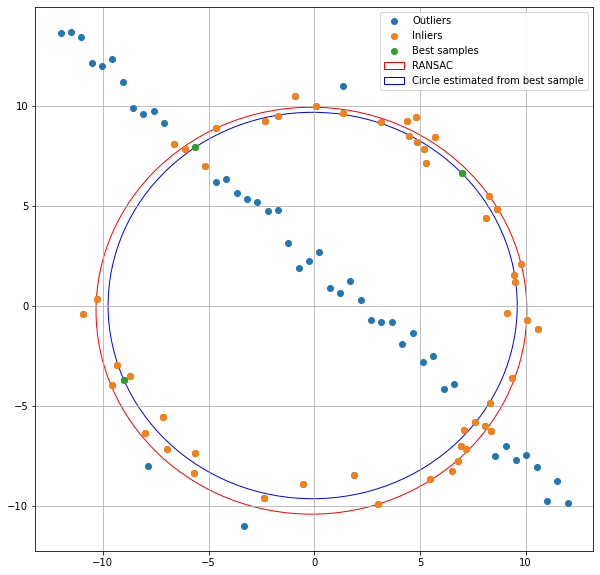

In [122]:
#1)
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

N = 100
half_n = N//2

R = 10
s = R/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)

x ,y = (R + n)*np.cos(t), (R + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X[:,0], X[:, 1], 'o', label='Outliers')
ax.grid(True)

#initializing variables
x_data = X[:, 0]
y_data = X[:, 1]
iterations = 100
inlier_threshold = R/8
inlier_count_threshold = 50
best_model = [0, 0, 999999, []]

#run iterations
for i in range(iterations):
    # get three points from data
    sample = getRandomPoints(X, 3)
    
    # calculate circle parameters from three points
    initial_circle = getCircleParams(sample)

    #eliminate larger circles
    if abs(R - initial_circle[2]) > 1.5*R:
        continue
    
    #calculate initial inliers 
    inliers, toal_distance = getInliersAndDistance(initial_circle, X, inlier_threshold)
    
    #if inlier count is less start from beginning
    if len(inliers) < inlier_count_threshold:
        continue

    # get three points from inliers
    inlier_sample = getRandomPoints(inliers, 3)
    
    # calculate circle parameters from three inlier points
    circle = getCircleParams(inlier_sample)

    #calculate new inliers and total absolute distance
    inliers, toal_distance = getInliersAndDistance(initial_circle, X, inlier_threshold)
    
    #if inlier count is less start from beginning
    if len(inliers) < inlier_count_threshold:
        continue
    
    #if new circle has more inliers change best model to this new circle
    #if same amount of inliers make the best model with the circle that has less absolute distance
    if len(best_model[-1]) < len(inliers):
        best_model = [circle, initial_circle, sample, toal_distance, inliers]
    elif len(best_model[-1]) == len(inliers):
        if best_model[3] > toal_distance:
            best_model = [circle, initial_circle, sample, toal_distance, inliers]

if len(best_model[-1]) == 0:
    print("No best model found")

else:
    inliers = np.array(best_model[-1])
    ax.plot(inliers[:, 0], inliers[:, 1], 'o', label='Inliers')

    best_samples = np.array(best_model[2])
    ax.plot(best_samples[:,0], best_samples[:, 1], 'o', label='Best samples')

    a, b, r = best_model[0][0], best_model[0][1], best_model[0][2]
    circle = Circle((a, b), radius=r, color='r', fc='y', fill=False, label='RANSAC')
    ax.add_patch(circle)

    a, b, r = best_model[1][0], best_model[1][1], best_model[1][2]
    init_circle = Circle((a, b), radius=r, color='b', fc='y', fill=False, label='Circle estimated from best sample')
    ax.add_patch(init_circle)

ax.legend();

In [78]:
#2)
import cv2 as cv

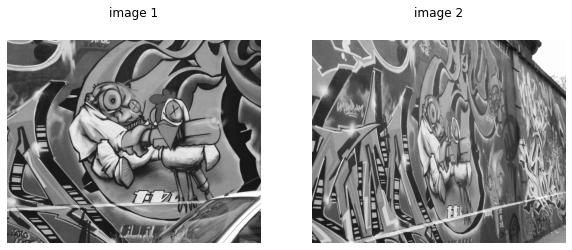

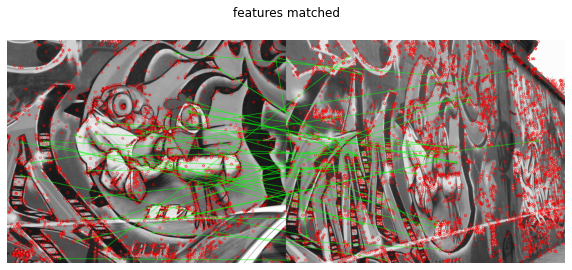

In [80]:
#3)
#a)
img1 = cv.imread(r'E:\Aca\aca sem 4\Image Processing & Machine vision\exercises\exercise_05\graffiti\img1.ppm', cv.IMREAD_GRAYSCALE)
assert img1 is not None

img5 = cv.imread(r'E:\Aca\aca sem 4\Image Processing & Machine vision\exercises\exercise_05\graffiti\img5.ppm', cv.IMREAD_GRAYSCALE)
assert img5 is not None

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img1, cmap = 'gray', vmin =0, vmax=255)
ax[0].title.set_text('image 1')
ax[0].axis('off')
ax[0].xaxis.tick_top()

ax[1].imshow(img5, cmap = 'gray', vmin =0, vmax=255)
ax[1].title.set_text('image 2')
ax[1].axis('off')
ax[1].xaxis.tick_top()

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img5,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
                   
img3 = cv.drawMatchesKnn(img1, kp1, img5, kp2, matches,None, **draw_params)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img3, cmap = 'gray', vmin =0, vmax=255)
ax.title.set_text('features matched')
ax.axis('off')
ax.xaxis.tick_top()

In [ ]:
#b)

In [ ]:
#c)